In [375]:
#!g1.1
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.utils.extmath import randomized_svd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch import utils
from torch.utils.data import DataLoader, random_split


from linearized_nns.estimator import Estimator
from linearized_nns.pytorch_impl.estimators import SgdEstimator
from linearized_nns.pytorch_impl.nns import Myrtle5, Myrtle7, Myrtle10
from linearized_nns.pytorch_impl import ClassifierTraining
from linearized_nns.pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from linearized_nns.pytorch_impl.nns.utils import to_one_hot, print_sizes
from linearized_nns.from_neural_kernels import to_zca, CustomTensorDataset, get_cifar_zca

In [394]:
#!g1.1
import psutil
psutil.virtual_memory()

svmem(total=101383163904, available=77596155904, percent=23.5, used=23074385920, free=57839542272, active=26365452288, inactive=15716737024, buffers=192172032, cached=20277063680, shared=31600640, slab=958316544)

In [346]:
#!g1.1
DEVICE = 'cuda'
NUM_CLASSES = 200

In [186]:
X_train[0]

array([[[-1.65183192, -1.91596214, -1.64195516, ...,  1.9336765 ,
          1.67671202,  1.69975139],
        [-2.84610129, -3.39586554, -2.7884646 , ...,  0.78048275,
          0.60957637,  0.45354291],
        [-2.77229456, -2.92845503, -1.82669088, ...,  0.59936793,
          0.62257471,  0.11226297],
        ...,
        [ 3.54200245,  2.91797545,  3.06100934, ...,  1.75178342,
         -1.4082283 , -1.6087027 ],
        [ 2.44707899,  1.93059543,  2.41982469, ...,  2.48208832,
         -0.21615934, -0.92305209],
        [ 2.26081823,  2.02074537,  2.52699937, ...,  3.47745633,
          1.35145709,  0.41484161]],

       [[-1.46052133, -1.89718217, -1.85113785, ...,  0.99272443,
          0.66214103,  0.78690635],
        [-2.68860227, -3.46902367, -3.15061115, ..., -0.35938946,
         -0.61944942, -0.65002576],
        [-2.68388894, -3.17448232, -2.44140125, ..., -0.57843441,
         -0.64878894, -1.06833615],
        ...,
        [ 2.35292974,  1.45741437,  1.5596361 , ...,  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

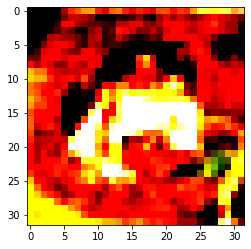

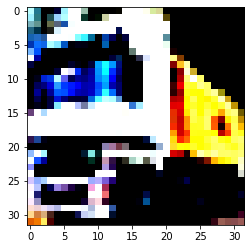

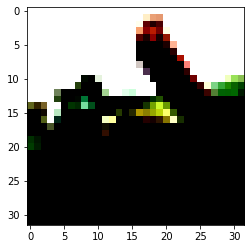

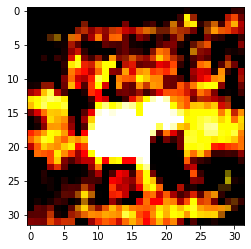

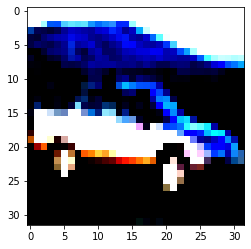

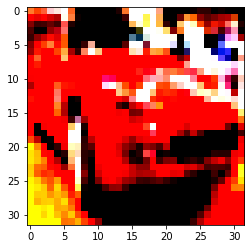

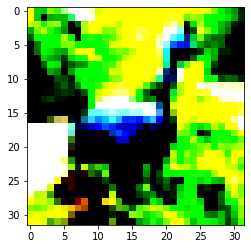

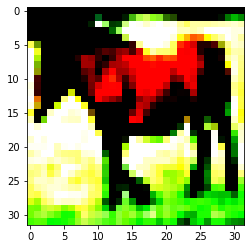

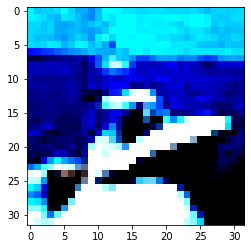

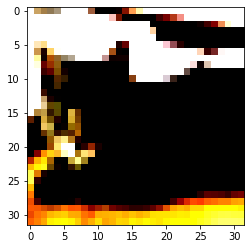

In [187]:
#!g1.1

for i in range(10):
    image = np.transpose(X_train[i], (1,2,0))
    plt.imshow(image)
    plt.show()

In [404]:
#!g1.1

class ZcaNumpy:
    def __init__(self, V, inv_sqrt_zca_eigs):
        self.V = V
        self.inv_sqrt_zca_eigs = inv_sqrt_zca_eigs
    
    def apply(self, batch):
        orig_shape = batch.shape
        batch = batch.reshape(batch.shape[0], -1).astype(np.float64)
        
        # normalize
        batch -= np.mean(batch, axis=1)[:,np.newaxis]
        batch /= np.linalg.norm(batch, axis=1)[:,np.newaxis]
        
        # apply zca
        batch = batch.dot(self.V.T).dot(self.inv_sqrt_zca_eigs).dot(self.V)
        return batch.reshape(orig_shape)

class ZcaTorch:
    def __init__(self, V, inv_sqrt_zca_eigs, device):
        self.V = torch.tensor(V, dtype=torch.float) \
            .to(device)
        self.inv_sqrt_zca_eigs = torch.tensor(inv_sqrt_zca_eigs, dtype=torch.float) \
            .to(device)
        self.device = device
    
    def apply(self, batch):
        orig_shape = batch.shape
        batch = batch.reshape(batch.shape[0], -1).float()
        
        # norimize
        batch -= batch.mean(dim=1, keepdim=True)
        batch /= torch.norm(batch, dim=1, keepdim=True)

        # apply zca
        batch = torch.mm(torch.mm(torch.mm(batch, self.V.T), self.inv_sqrt_zca_eigs), self.V)
        return batch.reshape(orig_shape)

def to_zca_faster(train, zca_bias=0.01, n_components=1000):
    print('faster zca')
    orig_train_shape = train.shape
    train = np.ascontiguousarray(train, dtype=np.float32).reshape(train.shape[0], -1)
    
    n_train = train.shape[0]
    
    # Zero mean every feature
    train = train - np.mean(train, axis=1)[:,np.newaxis]
    # Normalize
    train_norms = np.linalg.norm(train, axis=1)
    # Make features unit norm
    train = train/train_norms[:,np.newaxis]
    
    print(train[0])
    
    print('calculating svd...')
    
    _, S, V = randomized_svd(train, n_components=n_components)
    print('svd calculated. applying svd matricies.')
    S = (S ** 2) / n_train + zca_bias
    inv_sqrt_zca_eigs = np.diag(np.power(S, -1))
    
    print('faster zca done.')

    return ZcaTorch(V, inv_sqrt_zca_eigs, DEVICE)

def get_cifar_zca_fast():
    trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

    X_train = np.asarray(trainset.data[:10000]).astype(np.float64)
    y_train = np.asarray(trainset.targets)
    X_test  = np.asarray(testset.data).astype(np.float64)
    y_test  = np.asarray(testset.targets)

    zca = to_zca_faster(X_train, n_components=1000)

    X_train = zca.apply(torch.tensor(X_train).to(DEVICE)).cpu().numpy()
    X_test  = zca.apply(torch.tensor(X_test).to(DEVICE)).cpu().numpy()
    
    X_train = np.transpose(X_train, (0,3,1,2))
    X_test  = np.transpose(X_test,  (0,3,1,2))

    return X_train, y_train, X_test, y_test

X_train, _, X_test, _ = get_cifar_zca_fast()

Files already downloaded and verified
Files already downloaded and verified
faster zca
[-0.01542946 -0.01438804 -0.01404089 ...  0.00678755 -0.00397381
 -0.01091663]
calculating svd...
svd calculated. applying svd matricies.
faster zca done.


In [370]:
#!g1.1
X_train[0]

array([[[-1.588729  , -1.802852  , -1.68694   , ...,  1.4433362 ,
          1.1439549 ,  1.0021762 ],
        [-2.625303  , -3.1293752 , -2.6179774 , ...,  0.25307786,
          0.13242835, -0.02460276],
        [-2.5556574 , -2.6105886 , -1.4684688 , ...,  0.3018798 ,
          0.1277389 , -0.19497228],
        ...,
        [ 2.0205119 ,  1.5233611 ,  1.7803259 , ...,  0.8966025 ,
         -2.308588  , -2.5364532 ],
        [ 0.96116894,  0.6600709 ,  1.1251783 , ...,  1.6971825 ,
         -1.0576797 , -1.7218906 ],
        [ 0.60237527,  0.40091443,  0.9336165 , ...,  2.67718   ,
          0.45091856, -0.5773811 ]],

       [[-0.7414523 , -1.0129825 , -1.1701622 , ...,  1.1843911 ,
          0.94715285,  0.98738754],
        [-1.8207697 , -2.500772  , -2.371935  , ..., -0.19882761,
         -0.29249433, -0.25284073],
        [-1.7521564 , -2.119748  , -1.4344201 , ..., -0.17288986,
         -0.30696303, -0.4725522 ],
        ...,
        [ 1.7102026 ,  0.8257552 ,  1.160812  , ...,  

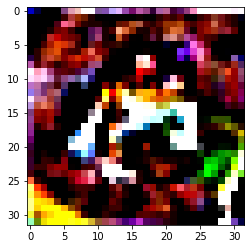

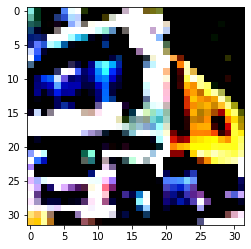

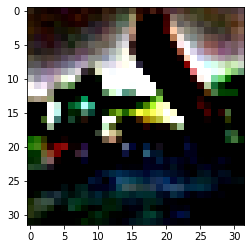

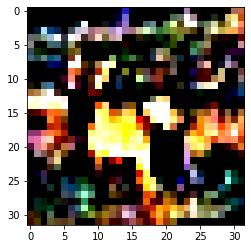

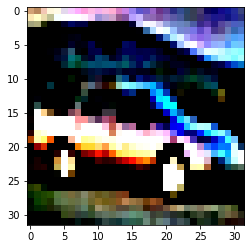

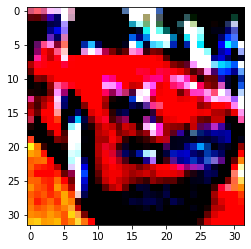

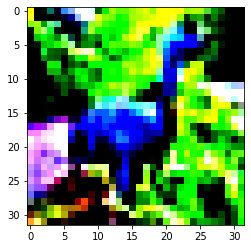

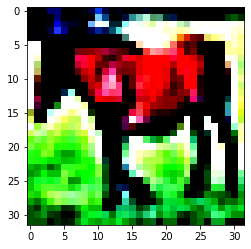

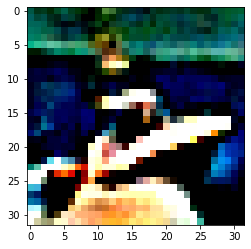

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

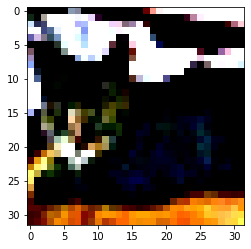

In [371]:
#!g1.1
for i in range(10):
    image = np.transpose(X_train[i], (1,2,0))
    plt.imshow(image)
    plt.show()

In [321]:
#!g1.1
def get_tiny_imagenet_zca(train_dir, test_dir):
    print('getting tiny-imagenet zca:')
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    
    print('loading datasets...')
    
    trainset = datasets.ImageFolder(train_dir, transform=transforms.ToTensor()) 
    testset  = datasets.ImageFolder(test_dir, transform=transforms.ToTensor())
    
    trainloader = utils.data.DataLoader(trainset, pin_memory=True, shuffle=True, batch_size=100000)
    testloader  = utils.data.DataLoader(testset,  pin_memory=True, shuffle=False, batch_size=10000)
    
    _, (X_train, y_train)  = next(enumerate(trainloader))
    _, (X_test,  y_test)   = next(enumerate(testloader))
    
    print('datasets loaded.')
    
    X_train = X_train.numpy().astype(np.float64)
    X_test  = X_test.numpy().astype(np.float64)
    
    print('calculating zca...')
    X_train, X_test = to_zca_faster(X_train, X_test, n_components=3000)
    print('zca_calulated.')
    return torch.tensor(X_train), y_train, torch.tensor(X_test), y_test

TRAIN_DIR = 'tiny-imagenet-200/train'
TEST_DIR  = 'tiny-imagenet-200/val'

X_train_full, labels_train_full, X_test_full, labels_test_full = get_tiny_imagenet_zca(TRAIN_DIR, TEST_DIR)

getting tiny-imagenet zca:
loading datasets...
datasets loaded.
calculating zca...
faster zca
[-0.00336678 -0.00447899 -0.00429362 ... -0.01170834 -0.01263518
 -0.01393276]
calculating svd...
svd calculated. applying svd matricies.
faster zca done.
zca_calulated.


In [376]:
#!g1.1

DATA_DIR = 'imagenet-r'

NUM_CLASSES = 200
DEVICE = 'cuda'
N = 30000
SEED = 42 

In [377]:
#!g1.1

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


dataset = datasets.ImageFolder(DATA_DIR, transform=val_transforms)
trainset, testset = random_split(dataset, lengths=[27000, 3000])

In [380]:
#!g1.1
trainloader = utils.data.DataLoader(trainset, shuffle=True, batch_size=3000)

_, (X_train, _)  = next(enumerate(trainloader))

In [381]:
#!g1.1
%%time
zca = to_zca_faster(X_train.cpu().numpy())

faster zca
[ 0.00253557  0.00259212  0.00264867 ... -0.00016432  0.00032491
  0.00095802]
calculating svd...
svd calculated. applying svd matricies.
faster zca done.
CPU times: user 14min 19s, sys: 1min 41s, total: 16min
Wall time: 2min 38s


In [382]:
#!g1.1
X_train_zca = zca.apply(X_train)

In [384]:
#!g1.1
X_train_zca[0].shape

torch.Size([3, 224, 224])

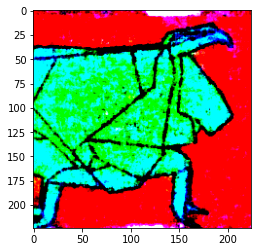

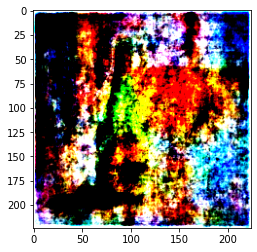

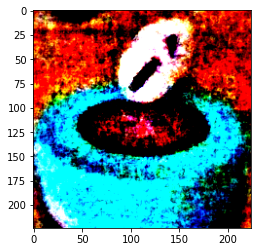

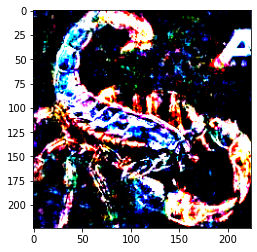

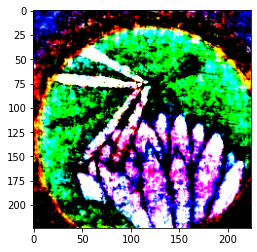

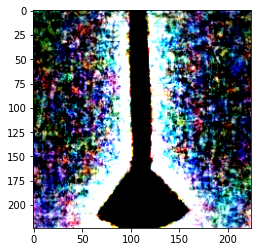

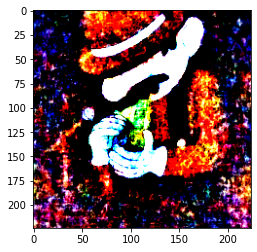

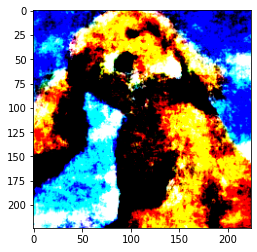

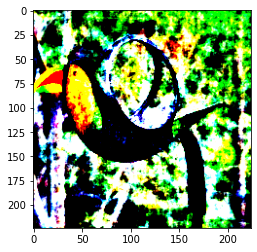

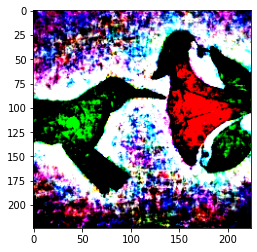

In [387]:
#!g1.1
for i in range(10):
    image = np.transpose(X_train_zca[i].cpu().numpy() * 10., (1,2,0))
    plt.imshow(image)
    plt.show()

In [406]:
#!g1.1
%%time
trainloader = utils.data.DataLoader(trainset, shuffle=True, batch_size=27000)
_, (X_train, _)  = next(enumerate(trainloader))
del trainloader
X_train = X_train.cpu().float().numpy()

print(f'trainset loaded, shape {X_train.shape}')

zca = to_zca_faster(X_train, n_components=3000)
print('zca done')
del X_train

trainset loaded, shape (27000, 3, 224, 224)
faster zca
[0.00095185 0.00057895 0.0005168  ... 0.00170767 0.00170767 0.00167604]
calculating svd...
svd calculated. applying svd matricies.
faster zca done.
zca done
CPU times: user 2h 29min 36s, sys: 5min 9s, total: 2h 34min 45s
Wall time: 24min 53s


In [393]:
#!g1.1
224 ** 2 * 3 * 27000 * 8

32514048000

In [408]:
#!g1.1
torch.save(zca.V, 'train_zca_V.pt')

In [409]:
#!g1.1
torch.save(zca.inv_sqrt_zca_eigs, 'train_zca_inv_sqrt_zca_eigs.pt')

In [410]:
#!g1.1
!ls -auxnh .

total 3.8G
drwxrwxrwx   5 1000 1000 4.0K May 11 14:45  .
drwxrwxrwx   4 1000 1000 4.0K May 11 11:39  ..
drwxrwxrwx   2 1000 1000 4.0K May 11 11:39  .ipynb_checkpoints
-rwxrwxrwx   1 1000    0  17K May 11 14:17 'Train classifier.ipynb'
-rwxrwxrwx   1 1000    0 497K May 11 14:17  Util.ipynb
-rw-rw-r--   1 1000 1000 400K May 11 12:53  ZCA-2.ipynb
-rw-rw-r--   1 1000 1000 1.5M May 11 14:35  ZCA.ipynb
drwxr-xr-x   3 1000 1000 4.0K May 11 12:24  data
drwxrwxrwx 202 1000 1000 4.0K May 11 11:39  imagenet-r
-rwxrwxrwx   1 1000 1000 2.1G May  9 22:45  imagenet-r.tar
-rw-r--r--   1 1000 1000 1.7G May 11 14:44  train_zca_V.pt
-rw-r--r--   1 1000 1000  35M May 11 14:45  train_zca_inv_sqrt_zca_eigs.pt


In [464]:
#!g1.1
from linearized_nns.pytorch_impl.nns.primitives import *

class Myrtle11(nn.Module):
    def __init__(self, num_classes=1, input_filters=3, num_filters=1, groups=1):
        super(Myrtle11, self).__init__()
        filters = num_filters

        def Activation():
            return ReLU2()

        self.layers = nn.Sequential(
            Conv(input_filters, filters * groups), Activation(),
            Conv(filters, filters * 2, groups),    Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            Conv(filters * 2, filters * 4, groups), Activation(),
            Conv(filters * 4, filters * 8, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),

            Conv(filters *  8, filters * 16, groups), Activation(),
            Conv(filters * 16, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters *  32, filters * 32, groups), Activation(),
            Conv(filters *  32, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters *  32, filters * 32, groups), Activation(),
            Conv(filters *  32, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            Conv(filters *  32, filters * 32, groups), Activation(),
            Conv(filters *  32, filters * 32, groups), Activation(),
            nn.AvgPool2d(kernel_size=7, stride=7),

            Flatten(),
            Normalize(filters * 32)
        )
        self.classifier = nn.Linear(filters * 32 * groups, num_classes, bias=True)

    def readout(self, x):
        return self.layers(x)

    def forward(self, x):
        x = self.readout(x)
        return self.classifier(x)

In [442]:
#!g1.1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

trainloader = DataLoader(trainset, shuffle=True, batch_size=1280)
testloader  = DataLoader(testset,  shuffle=True, batch_size=1000)

_, (X_train, labels_train) = next(enumerate(trainloader))
_, (X_test,  labels_test)  = next(enumerate(testloader))
del trainloader
del testloader

X_train = zca.apply(X_train.to(DEVICE))
X_test  = zca.apply(X_test.to(DEVICE))

In [443]:
#!g1.1
y_train = to_one_hot(labels_train, NUM_CLASSES).to(DEVICE)
y_test  = to_one_hot(labels_test,  NUM_CLASSES).to(DEVICE)

In [445]:
#!g1.1
def compute_kernels(models, X_train, X_test):
    with torch.no_grad():
        X_train = X_train.to(DEVICE)
        X_test  = X_test.to(DEVICE)

        n_train = len(X_train)
        n_test  = len(X_test)

        train_kernel = torch.zeros([n_train, n_train]).double().to(DEVICE)
        test_kernel  = torch.zeros([n_test,  n_train]).double().to(DEVICE)

        m = 0
        start_time = time.time()

        for model_i, model in enumerate(models):
            model = model.to(DEVICE)
            if model_i & (model_i - 1) == 0:
                print(f"{model_i} models done. time {time.time() - start_time:.0f}s")

            train_features = model.readout(X_train) 
            test_features  = model.readout(X_test)

            m += 1

            train_kernel += torch.matmul(train_features, train_features.T).double()
            test_kernel  += torch.matmul(test_features,  train_features.T).double()

        train_kernel /= m
        test_kernel  /= m

        return train_kernel.float(), test_kernel.float()

In [446]:
#!g1.1
model = Myrtle11().to(DEVICE)
model.forward(X_train)

tensor([[0.2145],
        [0.2200],
        [0.2272],
        ...,
        [0.1914],
        [0.2106],
        [0.2017]], device='cuda:0', grad_fn=<AddmmBackward>)

In [447]:
#!g1.1
X_train.shape, X_test.shape

(torch.Size([1280, 3, 224, 224]), torch.Size([1000, 3, 224, 224]))

In [449]:
#!g1.1

n_models = 1024
models = [Myrtle11(num_filters=1, groups=1) for _ in range(n_models)]

train_kernel, test_kernel = compute_kernels(models, X_train, X_test)

train_kernel = train_kernel.float().to(DEVICE)
test_kernel  = test_kernel.float().to(DEVICE)

0 models done. time 0s
1 models done. time 0s
2 models done. time 0s
4 models done. time 0s
8 models done. time 1s
16 models done. time 2s
32 models done. time 3s
64 models done. time 6s
128 models done. time 13s
256 models done. time 26s
512 models done. time 51s


In [450]:
#!g1.1
train_kernel[:5,:5]

tensor([[1.0000, 0.9949, 0.9933, 0.9975, 0.9955],
        [0.9949, 1.0000, 0.9951, 0.9955, 0.9943],
        [0.9933, 0.9951, 1.0000, 0.9942, 0.9938],
        [0.9975, 0.9955, 0.9942, 1.0000, 0.9967],
        [0.9955, 0.9943, 0.9938, 0.9967, 1.0000]], device='cuda:0')

In [451]:
#!g1.1
test_kernel[:5,:5]

tensor([[0.9962, 0.9924, 0.9915, 0.9950, 0.9947],
        [0.9943, 0.9946, 0.9945, 0.9953, 0.9948],
        [0.9963, 0.9946, 0.9930, 0.9959, 0.9940],
        [0.9918, 0.9931, 0.9919, 0.9924, 0.9934],
        [0.9965, 0.9960, 0.9948, 0.9974, 0.9963]], device='cuda:0')

In [452]:
#!g1.1
lr = 1e5

n = len(train_kernel)

exp_term = - lr * compute_exp_term(- lr * train_kernel, DEVICE)
y_pred = torch.matmul(test_kernel, torch.matmul(exp_term, - y_train))
(y_pred.argmax(dim=1) == labels_test.to(DEVICE)).float().mean()

tensor(0.0870, device='cuda:0')

In [ ]:
#!g1.1
del X_train
del X_test

In [454]:
#!g1.1
import time
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import FashionMNIST

from linearized_nns.estimator import Estimator
from linearized_nns.pytorch_impl.estimators import SgdEstimator
from linearized_nns.pytorch_impl.nns import Myrtle5, Myrtle7, Myrtle10
from linearized_nns.pytorch_impl import ClassifierTraining
from linearized_nns.pytorch_impl.matrix_exp import matrix_exp, compute_exp_term
from linearized_nns.pytorch_impl.nns.utils import to_one_hot, print_sizes
from linearized_nns.from_neural_kernels import to_zca, CustomTensorDataset, get_cifar_zca

In [458]:
#!g1.1
V                 = torch.load('train_zca_V.pt')
inv_sqrt_zca_eigs = torch.load('train_zca_inv_sqrt_zca_eigs.pt')

In [459]:
#!g1.1
V.shape, inv_sqrt_zca_eigs.shape

(torch.Size([3000, 150528]), torch.Size([3000, 3000]))

In [460]:
#!g1.1
zca = ZcaTorch(V, inv_sqrt_zca_eigs, DEVICE)

/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from typing import Optional, Dict, Set, Iterator, Callable, cast
/kernel/lib/python3.7/site-packages/ml_kernel/kernel.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [461]:
#!g1.1
class GpEstimator(Estimator):
    def __init__(self, models, n_classes, learning_rate, x_example, device, groups=1):
        super(GpEstimator, self).__init__()
        self.models    = [model.to(device) for model in models]
        self.lr        = learning_rate
        self.n_classes = n_classes
        self.device    = device
        
        n = len(models)
        X = torch.stack([x_example]).to(self.device)
        
        model = models[0].to(self.device)
        readout_size = model.readout(X).size()[1]
    
        # TODO: Assert that models have the same readout size
        
        self.w      = torch.zeros([n, readout_size, n_classes]).to(self.device)
        self.w_size = n * groups
        
    def get_w_update(self, X, right_vector):
        with torch.no_grad():
            assert len(X) == len(right_vector)

            X            = X.to(self.device)
            right_vector = right_vector.to(self.device)

            n = len(X)
            w_updates = []
            
            for model in self.models:
                features = self.to_model_features(X, model)
                update = torch.matmul(features.T, right_vector)
                w_updates.append(update)
            return torch.stack(w_updates)
                                  
    def to_model_features(self, X, model):
        with torch.no_grad():
            model = model.to(self.device)
            return model.readout(X) * (1. / np.sqrt(self.w_size))
        
    def calc_kernel(self, X):
        with torch.no_grad():
            X = X.to(self.device)
            
            res = torch.zeros([len(X), len(X)]).to(self.device).double()
            for model in self.models:
                features_x = self.to_model_features(X, model)
                
                res += torch.matmul(features_x, features_x.T).double()
            return res.float()
        
    def calc_kernel_pred(self, X):
        with torch.no_grad():
            X = X.to(self.device)
            
            n = len(X)
            y_pred = torch.zeros([n, self.n_classes]).to(self.device).double()
            kernel = torch.zeros([len(X), len(X)]).to(self.device).double()
            
            for model, w in zip(self.models, self.w):
                features = self.to_model_features(X, model)
                
                kernel += torch.matmul(features, features.T).double()
                y_pred += torch.matmul(features, w).double()
            return kernel, y_pred.float()
        
    def calc_kernels(self, X_train, X_test):
        with torch.no_grad():
            X_train = X_train.to(self.device)
            X_test  = X_test.to(self.device)
            
            res_train = torch.zeros([len(X_train), len(X_train)]).to(self.device)
            res_test  = torch.zeros([len(X_test),  len(X_train)]).to(self.device)
            for model in self.models:
                features_train = self.to_model_features(X_train, model)
                features_test  = self.to_model_features(X_test,  model)
                
                res_train += torch.matmul(features_train, features_train.T)
                res_test  += torch.matmul(features_test,  features_train.T)
            return res_train, res_test
            
    def predict(self, X, cur_w=None):
        X = X.to(self.device)
        if cur_w is None:
            cur_w = self.w
         
        with torch.no_grad():
            n = len(X)
            res = torch.zeros([n, self.n_classes]).double().to(self.device)

            for model, w in zip(self.models, cur_w):
                features = self.to_model_features(X, model)
                res += torch.matmul(features, w).double()
            return res.float()

In [474]:
#!g1.1
def calc_right_vector(kernel, y, learning_rate=1e5, reg_param=0):
    with torch.no_grad():
        y      = y.to(DEVICE)
        kernel = kernel.to(DEVICE)
        
        n      = len(kernel)
        reg = torch.eye(n).to(DEVICE) * reg_param
        
        exp_term = - learning_rate * compute_exp_term(- learning_rate * (kernel + reg), DEVICE)
        right_vector = torch.matmul(exp_term, - y)
        return right_vector

def boosting(estimator, train_loader, test_loader, zca, learning_rate=1e5, beta=1., noise_rate=0., n_iter=10):
    output_kernel = False
    
    with torch.no_grad():
        batches_num = 0
        for _ in enumerate(train_loader):
            batches_num += 1
        n_batches = (batches_num * 2) // 3 + 1
            
        for iter_num  in range(n_iter):
            print(f"iter {iter_num} ==========================")
            
            w_update = 0
            iter_start = time.time()
            
            for batch_i, (X, y) in enumerate(train_loader):
                if batch_i >= n_batches:
                    break
                
                X = zca.apply(X.to(DEVICE))
                y = to_one_hot(y, NUM_CLASSES).to(DEVICE)
                
                kernel, y_pred = estimator.calc_kernel_pred(X)
                if output_kernel:
                    print(f"kernel\n{kernel[:5,:5]}")
                
                y_residual = y_pred - y
                
                train_acc = (y_pred.argmax(dim=1) == y.argmax(dim=1)).float().mean().item()
                train_mse = (y_residual ** 2).mean().item()
                print(f"batch {batch_i}: train_acc {train_acc:.4f}, train_mse {train_mse:.6f}")
                
                right_vector = calc_right_vector(kernel, y_residual, learning_rate=learning_rate)
                
                w_update += estimator.get_w_update(X, right_vector).double()
                
                pred_change = torch.matmul(kernel, right_vector.double())
                

            w_update = (w_update / n_batches).float()
            
            w_std = w_update.std()
            noise = w_std * torch.randn(w_update.size()).to(DEVICE)
            estimator.w -= (w_update + noise_rate * noise) * beta 
            
            test_acc = 0
            for i, (X_test, labels) in enumerate(test_loader):
                X_test = zca.apply(X_test.to(DEVICE))
                labels = labels.to(DEVICE)
                
                y_pred = estimator.predict(X_test) 
                cur_acc   = (y_pred.argmax(dim=1) == labels).float().mean().item()
                test_acc += (cur_acc - test_acc) / (i + 1)
                
            print(f"iter {iter_num} done. took {time.time() - iter_start:.0f}s. beta {beta:.3f}, test_acc {test_acc:.4f}")
            print()

In [ ]:
#!g1.1
%state_exclude estimator
%state_exclude models

np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

train_loader = DataLoader(trainset, shuffle=True, batch_size=1000)
test_loader  = DataLoader(testset,  shuffle=True, batch_size=1000)

torch.manual_seed(0)
np.random.seed(0)

n_models = 1024
models = [Myrtle11(num_filters=1, groups=1) for _ in range(n_models)]

estimator = GpEstimator(models, NUM_CLASSES, 0.2, X_train[0], DEVICE, groups=10)
boosting(estimator, train_loader, test_loader, zca, learning_rate=1e5, n_iter=30)

iter 0 ==========================
batch 0: train_acc 0.0020, train_mse 1.000000
batch 1: train_acc 0.0030, train_mse 1.000000
batch 2: train_acc 0.0020, train_mse 1.000000
batch 3: train_acc 0.0050, train_mse 1.000000
batch 4: train_acc 0.0010, train_mse 1.000000
batch 5: train_acc 0.0040, train_mse 1.000000
batch 6: train_acc 0.0050, train_mse 1.000000
batch 7: train_acc 0.0040, train_mse 1.000000
batch 8: train_acc 0.0020, train_mse 1.000000
batch 9: train_acc 0.0050, train_mse 1.000000
batch 10: train_acc 0.0090, train_mse 1.000000
batch 11: train_acc 0.0030, train_mse 1.000000
batch 12: train_acc 0.0070, train_mse 1.000000
batch 13: train_acc 0.0010, train_mse 1.000000
batch 14: train_acc 0.0040, train_mse 1.000000
batch 15: train_acc 0.0020, train_mse 1.000000
batch 16: train_acc 0.0030, train_mse 1.000000
batch 17: train_acc 0.0030, train_mse 1.000000
batch 18: train_acc 0.0020, train_mse 1.000000
iter 0 done. took 2043s. beta 1.000, test_acc 0.1867

iter 1 ======================

In [ ]:
#!g1.1
